In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger # Comment out if not using wandb
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
import torch
# torch.multiprocessing.set_start_method('spawn', force=True)
from q2l_labeller.data.coco_data_module import COCODataModule
from q2l_labeller.pl_modules.query2label_train_module import Query2LabelTrainModule
from q2l_labeller.data.dataset import SeaThruAugmentation
pl.seed_everything(40)
torch.backends.cudnn.benchmark = True

param_dict = {
    "backbone_desc":"efficientnet_b3a",
    "conv_out_dim":1536,
    "hidden_dim":128,
    "num_encoders":1,
    "num_decoders":1,
    "num_heads":8,
    "batch_size":128,
    "image_dim":384,
    "learning_rate":1e-5,
    "momentum":0.9,
    "weight_decay":1e-3,
    "n_classes":4,
    "thresh":0.4,
    "use_cutmix":True,
    "use_pos_encoding":True,
    "loss":"ASL",
}

# train_classes = [160, 51, 119, 37, 52, 10, 88, 146, 125, 1, 260, 133, 9, 214, 70, 120, 111, 142, 274, 105, 69, 174, 203, 103, 228, 259, 205, 104, 116, 242, 16, 219, 81, 61, 100, 11, 224, 202, 82, 108, 255, 3, 54, 162, 85, 256, 8, 67, 71, 75, 173, 201, 93, 243, 218, 131, 99, 43, 36, 283]

# image_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset'
# depth_image_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train'
# depth_npy_folder = '/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train'
# seathru_parameters_path = '/home/mundus/mrahman528/Depth-Jitter/parameters_train.json'
image_folder = "/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020"
depth_image_folder = "/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020/depth_train"
depth_npy_folder = "/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020/depth_train"
seathru_parameters_path = "/home/mundus/mrahman528/thesis/thesis_paper/parameters_train.json"
seathru_transform = SeaThruAugmentation(image_folder, depth_image_folder, depth_npy_folder, seathru_parameters_path)

coco = COCODataModule(
    data_dir="/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020",
    img_size=384,
    batch_size=128,
    num_workers=8,  # Adjust based on CPU cores
    use_cutmix=True,
    cutmix_alpha=1.0,
    train_classes=None,
    sampling_strategy="default", # oversample, undersample, default
    augmentation_strategy="seathru",
    seathru_transform=seathru_transform
)

param_dict["data"] = coco

pl_model = Query2LabelTrainModule(**param_dict)

/home/mundus/mrahman528/miniconda3/envs/depth-jitter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 40


In [2]:
# Comment out if not using wandb
# wandb_logger = WandbLogger(
#     project="fathomnet_osd", 
#     save_dir="training/logs/fathomnet_with_all_seathru",
#     log_model=True)
# wandb_logger.watch(pl_model, log="all")

trainer = pl.Trainer(
    max_epochs=30,
    precision=16,
    accelerator='gpu', 
    devices='auto',  # Use all available GPUs
    # strategy='ddp',  # Use Distributed Data Parallel strategy
    # gradient_clip_val=0.5,  # Gradient clipping
    # logger=wandb_logger, # Comment out if not using wandb
    default_root_dir="training/checkpoints/depth_jitter",
    callbacks=[TQDMProgressBar(refresh_rate=100)],  # Reduce logging frequency
    accumulate_grad_batches=4,  # Accumulate gradients for larger batch size
    detect_anomaly=True,
    # profiler="simple"  # Profile to identify bottlenecks
)
trainer.fit(pl_model, param_dict["data"])


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


-----------------------------DEPTHJITTER AUGMENTATION INITIALIZED-------------------------------------
loading annotations into memory...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!



  | Name             | Type                | Params | Mode 
-----------------------------------------------------------------
0 | model            | Query2Label         | 12.1 M | train
1 | dropout          | Dropout             | 0      | train
2 | base_criterion   | BCEWithLogitsLoss   | 0      | train
3 | precision_metric | MultilabelPrecision | 0      | train
4 | recall_metric    | MultilabelRecall    | 0      | train
5 | f1_metric        | MultilabelF1Score   | 0      | train
6 | accuracy_metric  | MultilabelAccuracy  | 0      | train
-----------------------------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total params
48.594    Total estimated model params size (MB)
578       Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 41/41 [02:00<00:00,  0.34it/s, v_num=171, train_loss=0.449, val_loss=0.438, val_mAP=0.717, val_mAP@20=0.819]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [2]:
import json

with open("/home/mundus/mrahman528/thesis/thesis_paper/parameters_train.json", "r") as f:
    seathru_params = json.load(f)


In [4]:
import numpy as np

depth_dir = "/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020/depth_train"
depth_variances = []
for image_name, params in seathru_params.items():
    # Load the depth map
    depth_map_path = f"{depth_dir}/{image_name.split('.')[0]}_raw_depth_meter.npy"
    depth_data = np.load(depth_map_path)

    # Compute variance
    variance = np.var(depth_data)

    # Check if `betac` converged to lower bound for any channel
    converged_to_bound = any(params[f"channel_{ch}"]["betac"] <= 1e-6 for ch in range(3))

    # Append results
    depth_variances.append({"image": image_name, "variance": variance, "converged_to_bound": converged_to_bound})


In [5]:
import pandas as pd

df = pd.DataFrame(depth_variances)


In [6]:
case_a = df[df["converged_to_bound"]]
case_b = df[~df["converged_to_bound"]]


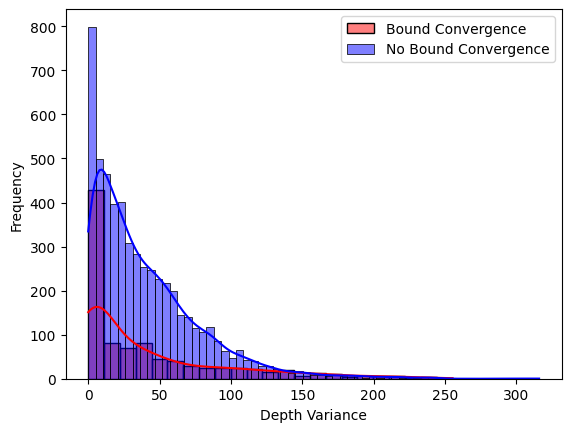

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(case_a["variance"], kde=True, color="red", label="Bound Convergence")
sns.histplot(case_b["variance"], kde=True, color="blue", label="No Bound Convergence")
plt.xlabel("Depth Variance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [8]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(case_a["variance"], case_b["variance"], equal_var=False)
print(f"T-test: t={t_stat}, p={p_value}")


T-test: t=0.7824737890610673, p=0.4340974676603866


In [9]:
threshold = case_b["variance"].mean()  # Example threshold: mean of Case B


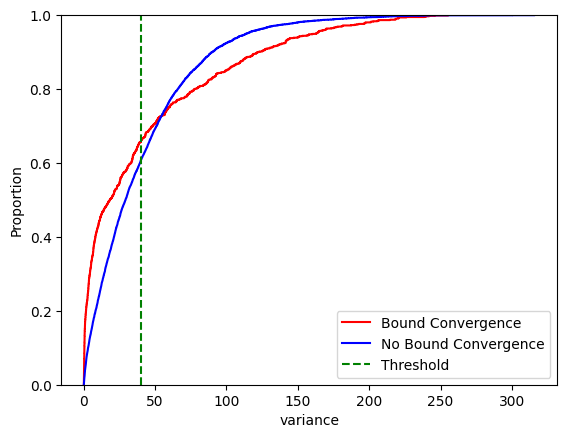

In [10]:
sns.ecdfplot(case_a["variance"], color="red", label="Bound Convergence")
sns.ecdfplot(case_b["variance"], color="blue", label="No Bound Convergence")
plt.axvline(x=threshold, color="green", linestyle="--", label="Threshold")
plt.legend()
plt.show()


In [11]:
df["augment"] = df["variance"] >= threshold

augmented_count = df["augment"].sum()
skipped_count = len(df) - augmented_count

print(f"Images Augmented: {augmented_count}")
print(f"Images Skipped: {skipped_count}")


Images Augmented: 2482
Images Skipped: 3979


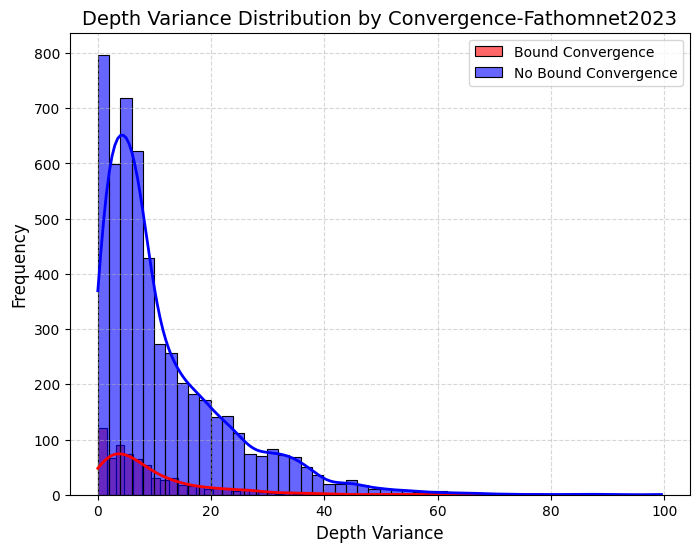

Threshold for Depth Variance: 3.66
Percentage of images below threshold: 25.01%


In [2]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load Sea-thru parameters
params_path = "/home/mundus/mrahman528/Depth-Jitter/parameters_train.json"
depth_dir = "/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train"

with open(params_path, "r") as f:
    seathru_params = json.load(f)

depth_variances = []

# Iterate through image parameters
for image_name, params in seathru_params.items():
    depth_map_path = os.path.join(depth_dir, f"{image_name.split('.')[0]}_raw_depth_meter.npy")

    # Ensure depth map exists before loading
    if not os.path.exists(depth_map_path):
        print(f"Warning: Missing depth file {depth_map_path}")
        continue

    # Load depth map and compute variance
    depth_data = np.load(depth_map_path)
    variance = np.var(depth_data)

    # Check if betac converged to lower bound for any channel
    converged_to_bound = any(params[f"channel_{ch}"]["betac"] <= 1e-6 for ch in range(3))

    # Append results
    depth_variances.append({
        "image": image_name,
        "variance": variance,
        "converged_to_bound": converged_to_bound
    })

# Convert to DataFrame
df = pd.DataFrame(depth_variances)

# Split into two cases
case_a = df[df["converged_to_bound"]]
case_b = df[~df["converged_to_bound"]]

# Visualization
plt.figure(figsize=(8, 6))
sns.histplot(case_a["variance"], kde=True, bins=50, color="red", label="Bound Convergence", alpha=0.6, line_kws={'linewidth': 2})
sns.histplot(case_b["variance"], kde=True, bins=50, color="blue", label="No Bound Convergence", alpha=0.6, line_kws={'linewidth': 2})
plt.xlabel("Depth Variance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Depth Variance Distribution by Convergence-Fathomnet2023", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Threshold Experimentation
threshold = df["variance"].quantile(0.25)  # Example: Lower quartile
excluded_images = df[df["variance"] < threshold]
percentage_excluded = len(excluded_images) / len(df) * 100

print(f"Threshold for Depth Variance: {threshold:.2f}")
print(f"Percentage of images below threshold: {percentage_excluded:.2f}%")


In [3]:
import os
import json
import numpy as np
from pathlib import Path

# Set your depth folder paths
depth_npy_folder = "/home/mundus/mrahman528/projects/mir/depth_jitter/fathomnet_2023_dataset/depth_vis_train"

# Dictionary to store depth variances
depth_variances = {}

# Iterate through depth `.npy` files
for npy_file in Path(depth_npy_folder).glob("*.npy"):
    image_name = npy_file.stem.replace("_raw_depth_meter", "") + ".jpg"  # Match original image names

    # Load depth map
    depth_data = np.load(npy_file)

    # Compute variance
    variance = np.var(depth_data)

    # Convert numpy float32 to Python float
    depth_variances[image_name] = float(variance)

# Save the results to a JSON file
output_json_path = "/home/mundus/mrahman528/Depth-Jitter/depth_variance_fathomnet.json"
with open(output_json_path, "w") as f:
    json.dump(depth_variances, f, indent=4)

print(f"Saved depth variances for {len(depth_variances)} images to {output_json_path}")


Saved depth variances for 5950 images to /home/mundus/mrahman528/Depth-Jitter/depth_variance_fathomnet.json


In [5]:
import numpy as np
import json
import os
from pathlib import Path

depth_npy_folder = "/home/mundus/mrahman528/thesis/thesis_paper/UTDAC2020/depth_train"

depth_stats = {"min": [], "max": [], "mean": [], "std": []}

# Iterate through all depth maps
for npy_file in Path(depth_npy_folder).glob("*.npy"):
    depth_data = np.load(npy_file)

    # Remove invalid depth values if necessary (e.g., NaNs or zeros)
    valid_depths = depth_data[depth_data > 0]

    if valid_depths.size > 0:
        depth_stats["min"].append(np.min(valid_depths))
        depth_stats["max"].append(np.max(valid_depths))
        depth_stats["mean"].append(np.mean(valid_depths))
        depth_stats["std"].append(np.std(valid_depths))

# Compute aggregated statistics
depth_range = {
    "global_min": float(np.min(depth_stats["min"])),
    "global_max": float(np.max(depth_stats["max"])),
    "mean_depth": float(np.mean(depth_stats["mean"])),
    "std_depth": float(np.mean(depth_stats["std"])),
    "p10": float(np.percentile(depth_stats["mean"], 10)),  # 10th percentile
    "p90": float(np.percentile(depth_stats["mean"], 90)),  # 90th percentile
}

print("Depth Statistics:", depth_range)


Depth Statistics: {'global_min': 2.6692309379577637, 'global_max': 65.86357116699219, 'mean_depth': 11.713912963867188, 'std_depth': 5.515598773956299, 'p10': 6.953379154205322, 'p90': 16.670053482055664}
